In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
rc('text',
   usetex=True)
sns.set_style('ticks')
sns.set_style({'font.family':'sans-serif'})
flatui = ['#002A5E', '#FD151B', '#8EBA42', '#348ABD', '#988ED5', '#BDB76B', '#8EBA42', '#FFB5B8']
sns.set_palette(flatui)
paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

# Parse Job Completion Times

In [2]:
import ast
import os
import re
def parse_directory(directory_name):
    directory = os.fsencode(directory_name)
    policy_names = []
    all_job_completion_times = []
    all_events = []
    for file in os.listdir(directory):
        file_name = os.fsdecode(file)
        policy_name = file_name.replace(".out", "")
        job_completion_times = None
        events = {}
        with open(os.path.join(directory_name, file_name), 'r') as f:
            parse_next_line = False
            for line in f:
                if parse_next_line:
                    line = line.strip()
                    job_completion_times = ast.literal_eval(line)
                    parse_next_line = False
                if line.strip() == "Job completion times:":
                    parse_next_line = True
                regex = r'\[Job ID: (\d+), Worker ID: (\d+) \[(.*)\]\] Start: (\d+), End: (\d+)'
                m = re.match(regex, line.strip())
                if m is not None:
                    job_id = int(m.group(1))
                    worker_id = int(m.group(2))
                    worker_type = m.group(3)
                    start = int(m.group(4))
                    end = int(m.group(5))
                    if worker_id not in events:
                        events[worker_id] = []
                    events[worker_id].append((job_id, worker_type, start, end))
        if job_completion_times is not None:
            policy_names.append(policy_name)
            all_job_completion_times.append(list(job_completion_times.values()))
            all_events.append(events)
    return all_job_completion_times, all_events, policy_names

# Plot Job Completion Time CDFs

In [3]:
def plot_jct_cdf(all_job_completion_times, policy_names):
    plt.figure(figsize=(10, 3.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    for (job_completion_times, policy_name) in zip(
        all_job_completion_times, policy_names):
        job_completion_times.sort()
        print("%s: %.4f" % (policy_name,
                            sum(job_completion_times) / len(job_completion_times)))
        cumulative_job_completion_times = [0.0]
        for x in job_completion_times:
            cumulative_job_completion_times.append(x)
        cumulative_percentages = [((i+1) * 100.0) / (len(cumulative_job_completion_times)+1)
                                  for i in range(len(cumulative_job_completion_times))]

        policy_name = policy_name.replace("_", "\_")
        ax.plot([0] + job_completion_times,
                cumulative_percentages, label=policy_name)

    ax.set_xlabel("Job Completion Time")
    ax.set_ylabel("Percentile (\%)")
    ax.set_xlim([0, None])
    ax.set_ylim([0, 100])
    
    plt.legend(loc='best')
    plt.show()

ks: 10903583.9414
ks_normalized: 8802962.3463
fifo: 7307725.2410
isolated: 10751492.1638


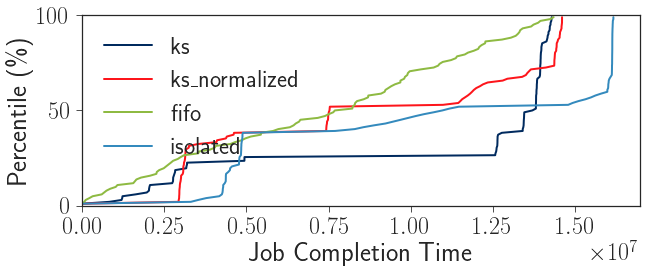

In [4]:
all_job_completion_times, _, policy_names = parse_directory(
    "../logs/poisson_lam=2000/")
plot_jct_cdf(all_job_completion_times, policy_names)

ks_normalized: 227841.5216
fifo: 400741.0653
isolated: 325879.4722


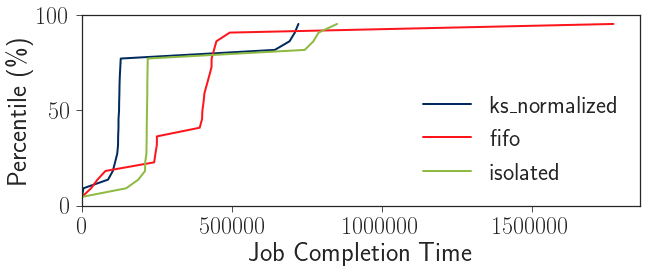

In [5]:
all_job_completion_times, _, policy_names = parse_directory(
    "../logs/poisson_lam=2000_more_short/")
plot_jct_cdf(all_job_completion_times, policy_names)

ks: 270148.4342
ks_normalized: 352415.2022
fifo: 311988.8153
isolated: 337586.1974


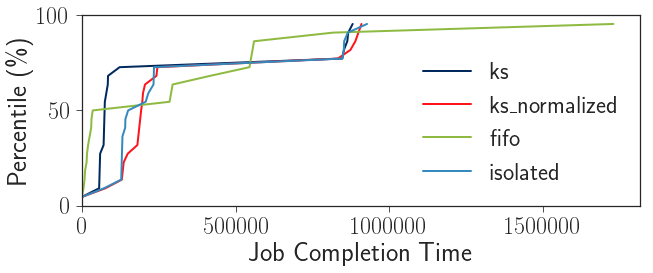

In [6]:
all_job_completion_times, _, policy_names = parse_directory(
    "../logs/constant_more_short/")
plot_jct_cdf(all_job_completion_times, policy_names)

ks: 217866.8957
ks_normalized: 241516.2850
fifo: 339701.7064
isolated: 239122.0093


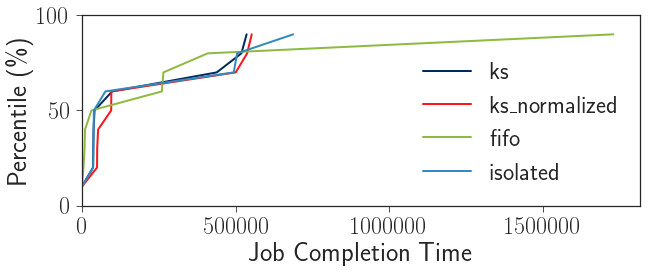

In [7]:
all_job_completion_times, _, policy_names = parse_directory(
    "../logs/constant_more_short_test/")
plot_jct_cdf(all_job_completion_times, policy_names)

# Plot event timeline

In [8]:
def plot_events(all_events, policy_names, xstart=None, xend=None):
    for (events, policy_name) in zip(all_events, policy_names):
        print("Policy name: %s" % policy_name)
        
        plt.figure(figsize=(20, 3.5))
        ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

        max_worker_id = None
        max_end = None
        worker_id_to_type_mapping = {}
        for worker_id in events:
            if max_worker_id is None or worker_id > max_worker_id:
                max_worker_id = worker_id
            for (job_id, worker_type, start, end) in events[worker_id]:
                if max_end is None or end > max_end:
                    max_end = end
                if worker_id not in worker_id_to_type_mapping:
                    worker_id_to_type_mapping[worker_id] = worker_type
                ax.plot([start, end], [worker_id, worker_id],
                        linewidth=10, c="C%d" % (job_id % 10))

        ax.set_xlabel("Time")
        ax.set_ylabel("Worker ID")
        if max_end is not None:
            if xstart is None:
                xstart = 0
            if xend is None:
                xend = (max_end + 1)
            ax.set_xlim([xstart, xend])
        if max_worker_id is not None:
            print(worker_id_to_type_mapping)
            ax.set_ylim([-0.5, max_worker_id+0.5])

        plt.legend()
        plt.show()

Policy name: ks


No handles with labels found to put in legend.


{0: 'v100', 2: 'k80', 1: 'p100'}


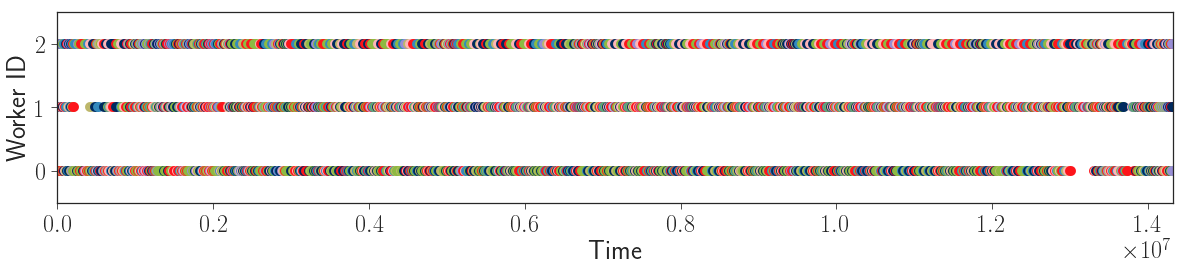

Policy name: ks_normalized


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


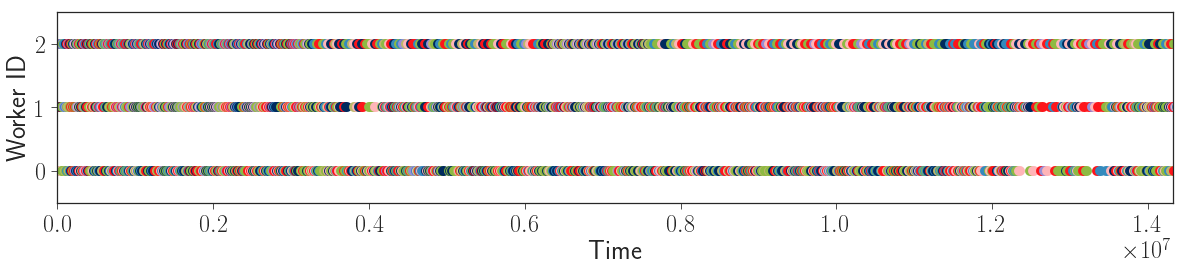

Policy name: fifo


No handles with labels found to put in legend.


{2: 'k80', 0: 'v100', 1: 'p100'}


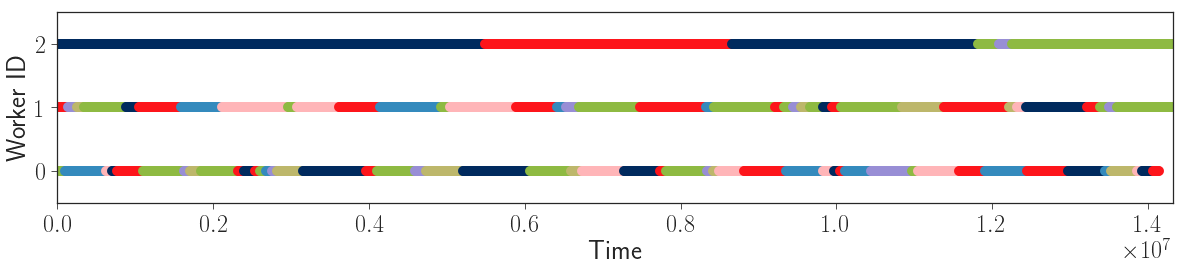

Policy name: isolated


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


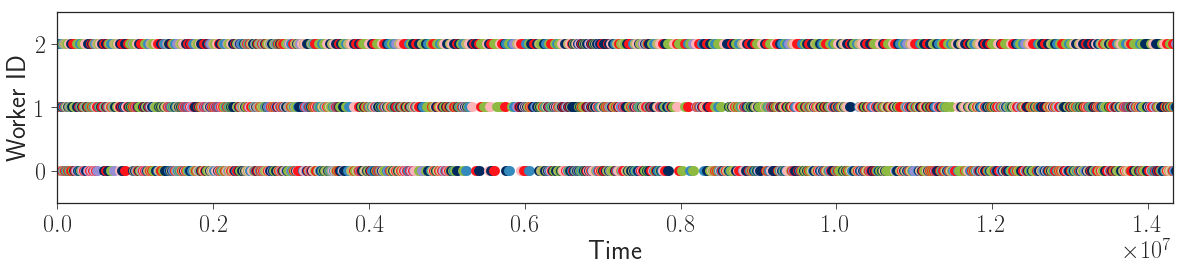

In [9]:
_, all_events, policy_names = parse_directory("../logs/poisson_lam=2000/")
plot_events(all_events, policy_names)

Policy name: ks_normalized


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


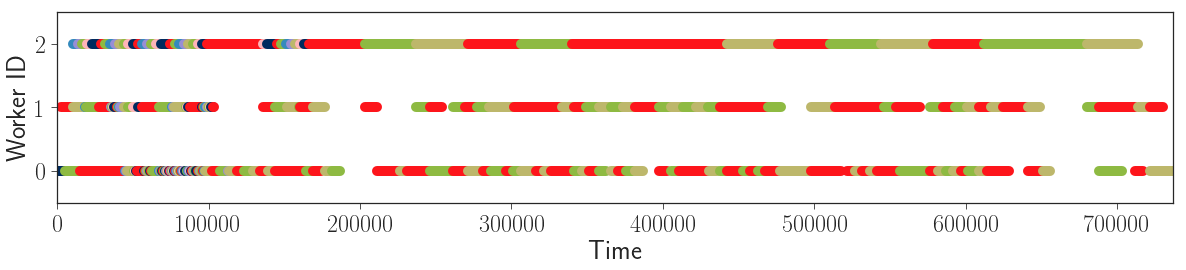

Policy name: fifo


No handles with labels found to put in legend.


{2: 'k80', 0: 'v100', 1: 'p100'}


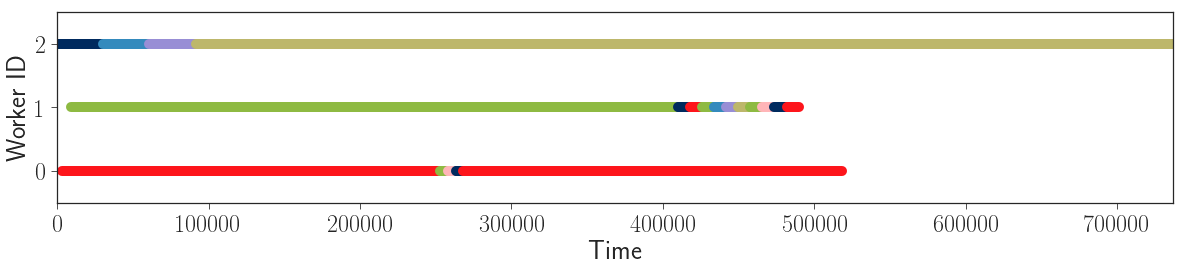

Policy name: isolated


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


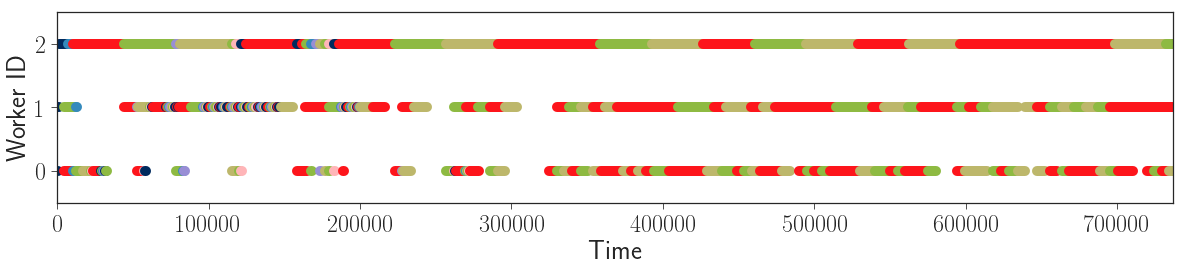

In [10]:
_, all_events, policy_names = parse_directory("../logs/poisson_lam=2000_more_short/")
plot_events(all_events, policy_names)

Policy name: ks


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


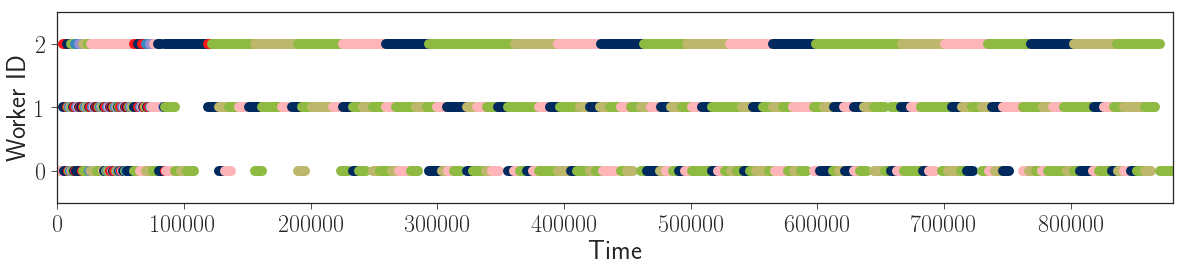

Policy name: ks_normalized


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


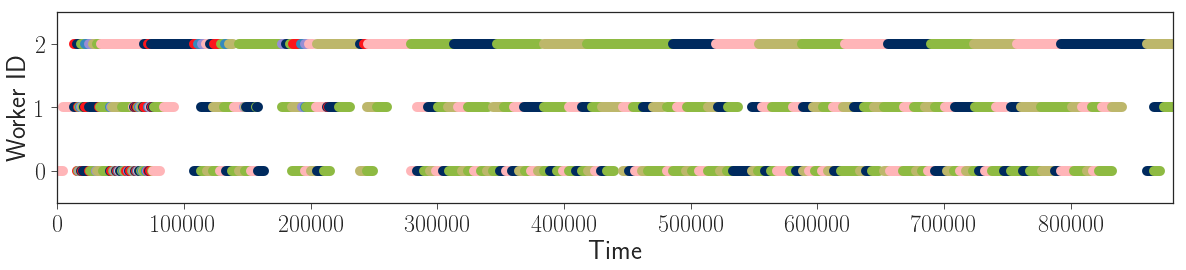

Policy name: fifo


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


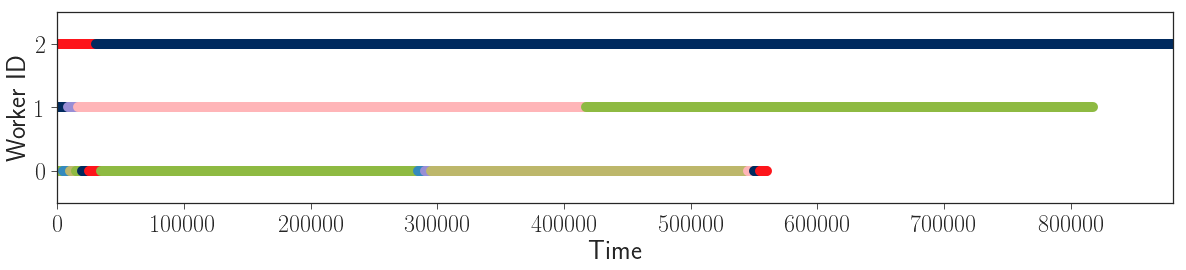

Policy name: isolated


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


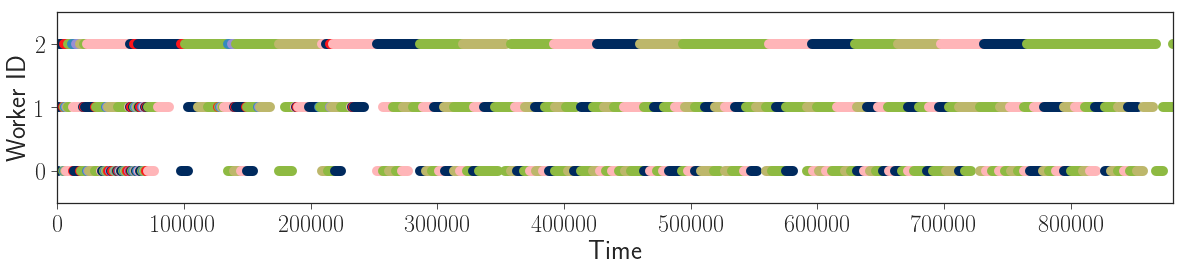

In [11]:
_, all_events, policy_names = parse_directory("../logs/constant_more_short/")
plot_events(all_events, policy_names)

Policy name: ks


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


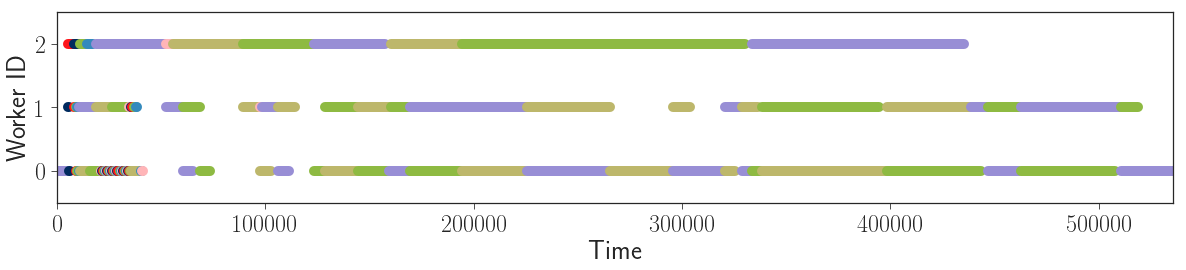

No handles with labels found to put in legend.


Policy name: ks_normalized
{0: 'v100', 1: 'p100', 2: 'k80'}


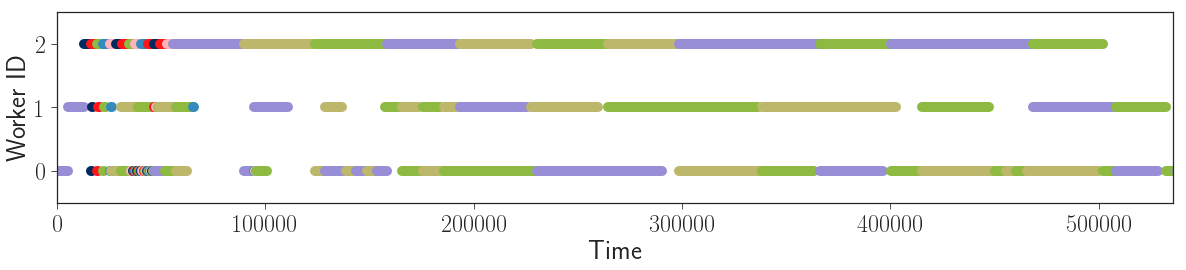

Policy name: fifo


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


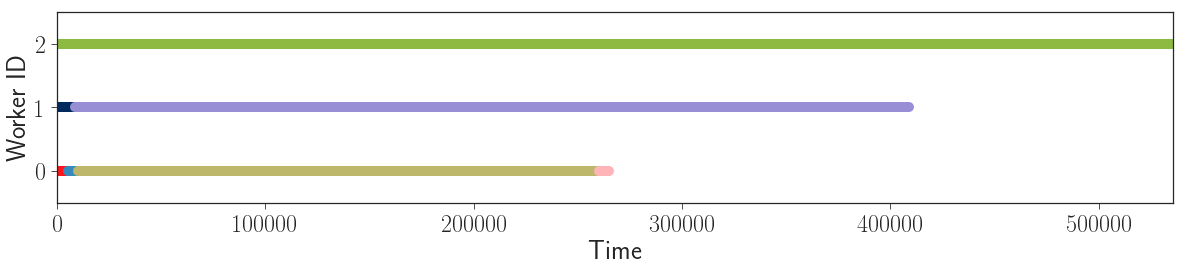

Policy name: isolated


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


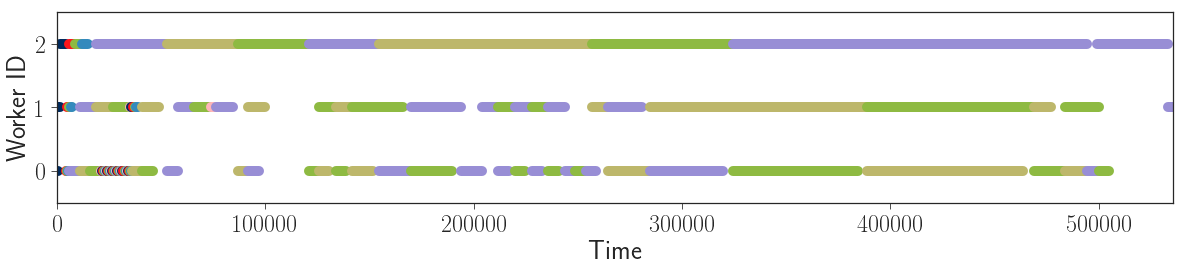

In [12]:
_, all_events, policy_names = parse_directory("../logs/constant_more_short_test/")
plot_events(all_events, policy_names)

Policy name: ks


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


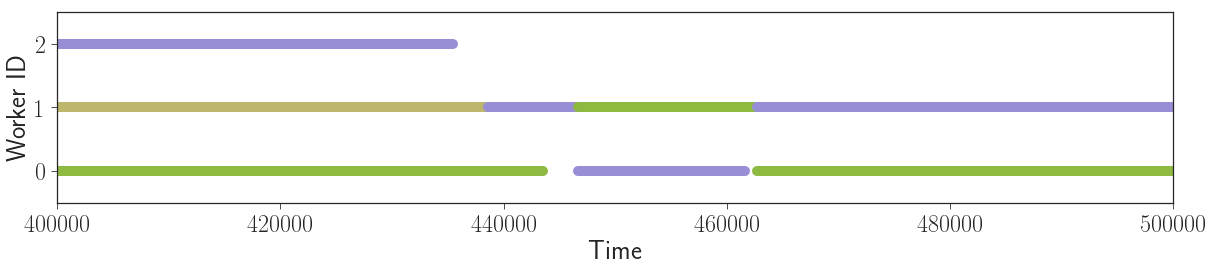

Policy name: ks_normalized


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


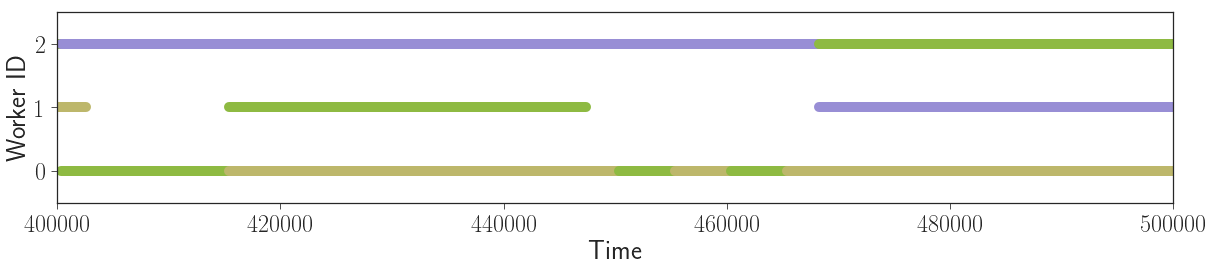

Policy name: fifo


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


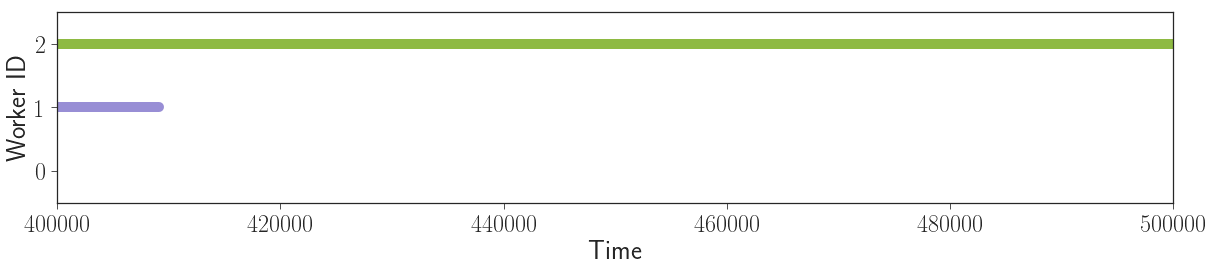

Policy name: isolated


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


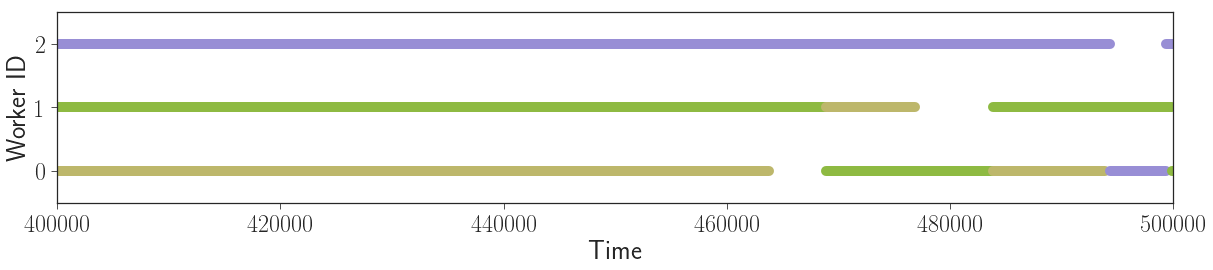

In [13]:
_, all_events, policy_names = parse_directory("../logs/constant_more_short_test/")
plot_events(all_events, policy_names, xstart=400000, xend=500000)